In [1]:
import pandas as pd
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split
import re
import dill as pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from tqdm import tqdm_notebook as tqdm
import time

In [2]:
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding='latin-1')
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding='latin-1')
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding='latin-1')
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/home/groot/anaconda3/lib/python3.6/site-packages/IPython/core/interactive

<h1> -------------------- KNN Begins -------------------- </h1>

In [3]:
combine_book_rating = pd.merge(ratings, books, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [4]:
combine_book_rating = combine_book_rating[combine_book_rating.bookRating != 0]
combine_book_rating.shape

(383842, 4)

In [5]:
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
1,2313,034545104X,5,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel
9,50403,034545104X,9,Flesh Tones: A Novel
13,63970,034545104X,8,Flesh Tones: A Novel


In [6]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['userID'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalUserRatingCount'})
     [['userID', 'totalUserRatingCount']]
    )
book_ratingCount.head()

,userID,totalUserRatingCount
0,8,7
1,9,1
2,12,1
3,14,3
4,16,1


In [7]:
book_ratingCount.shape

(68091, 2)

In [8]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'userID', right_on = 'userID', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalUserRatingCount
0,2313,034545104X,5,Flesh Tones: A Novel,28
1,8680,034545104X,5,Flesh Tones: A Novel,16
2,10314,034545104X,9,Flesh Tones: A Novel,64
3,50403,034545104X,9,Flesh Tones: A Novel,1
4,63970,034545104X,8,Flesh Tones: A Novel,2


In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalUserRatingCount'].describe())

count   68091.000
mean        5.637
std        41.743
min         1.000
25%         1.000
50%         1.000
75%         3.000
max      6943.000
Name: totalUserRatingCount, dtype: float64


In [10]:
print(book_ratingCount['totalUserRatingCount'].quantile(np.arange(.9, 1, .01)))

0.900    9.000
0.910   10.000
0.920   12.000
0.930   13.000
0.940   16.000
0.950   19.000
0.960   23.000
0.970   31.000
0.980   44.000
0.990   74.100
Name: totalUserRatingCount, dtype: float64


In [11]:
regularity_threshold = 50
rating_regular_user = rating_with_totalRatingCount.query('totalUserRatingCount >= @regularity_threshold')
rating_regular_user.head()

,userID,ISBN,bookRating,bookTitle,totalUserRatingCount
2,10314,034545104X,9,Flesh Tones: A Novel,64
5,77480,034545104X,8,Flesh Tones: A Novel,84
7,98391,034545104X,9,Flesh Tones: A Novel,5691
9,115435,034545104X,5,Flesh Tones: A Novel,91
15,208406,034545104X,6,Flesh Tones: A Novel,100


In [12]:
rating_regular_user.shape

(153424, 5)

In [13]:
combined = rating_regular_user.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalUserRatingCount,Location
0,10314,034545104X,9,Flesh Tones: A Novel,64,"beaverton, oregon, usa"
1,77480,034545104X,8,Flesh Tones: A Novel,84,"gig harbor, washington, usa"
2,98391,034545104X,9,Flesh Tones: A Novel,5691,"morrow, georgia, usa"
3,115435,034545104X,5,Flesh Tones: A Novel,91,"cincinnati, ohio, usa"
4,208406,034545104X,6,Flesh Tones: A Novel,100,"kansas city, missouri, usa"


In [16]:
us_canada_user_rating = us_canada_user_rating.drop(['Location','totalUserRatingCount'],axis=1)
us_canada_user_rating.head()

ValueError: labels ['Location' 'totalUserRatingCount'] not contained in axis

<h1>Generate Training Set</h1>

In [30]:
ratings_df = us_canada_user_rating.drop(columns={'bookTitle'})

In [18]:
counts1 = ratings['userID'].value_counts() #No of ratings users have done
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)] #exclude users with less than 200 ratings

counts = ratings['bookRating'].value_counts()  #No of rating book has got
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)] #exclude book with less than 100 ratings

In [31]:
ratings_train_df, ratings_test_df = train_test_split(ratings_df,
                                   stratify=ratings_df['userID'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(ratings_train_df))
print('# interactions on Test set: %d' % len(ratings_test_df))

# interactions on Train set: 98596
# interactions on Test set: 24650


In [41]:
books_df = pd.Series(ratings_df.ISBN.unique())
books_df.shape

(70224,)

In [39]:
len(ratings_df.userID.unique())

967

In [40]:
ratings_df.describe()

,userID,bookRating
count,123246.000,123246.000
mean,138229.107,7.831
std,77345.653,1.815
min,254.000,1.000
25%,76499.000,7.000
50%,135149.000,8.000
75%,204864.000,9.000
max,278418.000,10.000


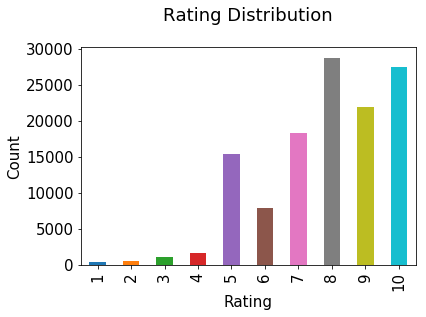

In [38]:
import matplotlib.pyplot as plt
#check the ratings distributions
plt.rc("font", size=15)
ratings_df.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('ratingDistribution.png', bbox_inches='tight')

In [19]:
len(ratings_train_df.userID.unique())

967

In [19]:
#Indexing by personId to speed up the searches during evaluation
ratings_full_indexed_df = ratings_df.set_index('userID')
ratings_train_indexed_df = ratings_train_df.set_index('userID')
ratings_test_indexed_df = ratings_test_df.set_index('userID')

<h1>Popular model</h1>

In [205]:
#Computes the most popular items
book_popularity_df = ratings_train_df.groupby('ISBN')['bookRating'].sum().sort_values(ascending=False).reset_index()
book_popularity_df = book_popularity_df.merge(books, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['bookRating', 'ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']]
book_popularity_df.dropna(inplace=True)
book_popularity_df = book_popularity_df.drop(['bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL'], axis=1)

def save(fname, data):
    file = open(fname+".txt","w+")
    file.write(str(data))
    file.close()

class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, books_df=None):
        self.popularity_df = popularity_df
        self.books_df = books_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, books_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['ISBN'].isin(books_to_ignore)] \
                               .sort_values('bookRating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.books_df is None:
                raise Exception('"books_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.books_df, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['bookRating', 'ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']]


        return recommendations_df
    
popularity_model = PopularityRecommender(book_popularity_df, books)

<h1>User-User Based</h1>

In [20]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

us_canada_user_rating = ratings_train_df.drop_duplicates(['userID', 'ISBN'])
# create pivot table i.e index = bookTitle and columns = UserId
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'userID', columns = 'ISBN', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)


model_knn_user = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn_user.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [21]:
us_canada_user_rating_pivot.columns.shape

(59431,)

In [22]:
us_canada_user_rating_pivot.head()

ISBN,000104799X,0001053736,0001053744,0001056107,0001714600,0001821326,0001952803,0002005050,0002005557,0002006588,...,9997411870,9997412044,9997507002,9997508769,B00005TZWI,B00006I4OX,B0000C2W5U,B0001GMSV2,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
254,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
638,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1733,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [23]:
us_canada_user_rating_pivot.iloc[0, :].values.reshape(1, -1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [23]:
def feedGen(userId=8):
    cols = list(us_canada_user_rating_pivot.columns)
    listOfBooks = ['16 Lighthouse Road','10 Lb. Penalty']
    indexOf = [cols.index(i) for i in listOfBooks]
    indices = [int(i) for i in indexOf]
    replacements = [9,4]
    populate = [0.]*len(cols)
    for i in indices:
        populate[i] = replacements[indices.index(i)]
    return np.asarray(populate).reshape(1, -1)

sample = feedGen()

ValueError: '16 Lighthouse Road' is not in list

In [ ]:
sample

In [24]:
knn_user_model.getSimilarUsers(1,sample)

NameError: name 'knn_user_model' is not defined

In [246]:
class KNNUserRecommender:
    
    MODEL_NAME = 'KNN'
    
    def __init__(self,pd,model_knn, users=None, books=None,us_canada_user_rating=None,us_canada_user_rating_pivot=None):
        self.model_knn = model_knn
        self.us_canada_user_rating = us_canada_user_rating
        self.user_rating_pivot = us_canada_user_rating_pivot
        self.users = users
        self.books = books
        self.pd = pd
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def getSimilarUsers(self,user_id,query=[]):
        try:
            query_index = self.user_rating_pivot.index.get_loc(user_id)
        except KeyError:
            if(len(query) != 0):
                distances, indices = self.model_knn.kneighbors(query, n_neighbors = 100)
                users = []
                distance = []
                for i in range(0, len(distances.flatten())):
                    users.append(self.user_rating_pivot.index[indices.flatten()[i]])
                    distance.append(distances.flatten()[i])
                return self.pd.DataFrame({'userID':users,'Distance':distance}).sort_values(by='Distance', ascending=False)
            
            else:
                return self.pd.DataFrame({'userID':[],'Distance':[]})
        
        distances, indices = self.model_knn.kneighbors(self.user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 100)
        users = []
        distance = []
        for i in range(0, len(distances.flatten())):
            users.append(self.user_rating_pivot.index[indices.flatten()[i]])
            distance.append(distances.flatten()[i])
        
        return self.pd.DataFrame({'userID':users,'Distance':distance}).sort_values(by='Distance', ascending=False)
        
    def recommend_users(self, user_id, topn=10):
        # Recommend the more popular items that the user hasn't seen yet.
        self.popularity_df = self.getSimilarUsers(user_id)
        
        if(self.popularity_df.empty):
            return self.popularity_df
       
        recommendations_df = self.popularity_df
        
        return recommendations_df.head(topn)
    
    def predict_item_rating(self, user_id, book):
        similiarUsers = list(self.recommend_users(user_id).userID)
        ratings = []
        for user in similiarUsers:
            ratings.extend(list(self.us_canada_user_rating.loc[self.us_canada_user_rating['userID'] == user].bookRating))
        return sum(ratings)/len(ratings)
    
    def recommend_items(self,user_id, books_to_ignore=[], topn=10, verbose=False):
        similiarUsers_df = self.recommend_users(user_id, topn)
        similiarUsers = list(similiarUsers_df.userID)
        books = []
        for user in similiarUsers:
            user_rating_df = self.us_canada_user_rating.loc[self.us_canada_user_rating['userID'] == user]
            user_rated_books = list(user_rating_df.ISBN)
            for book in user_rated_books:
                rating = list(user_rating_df.loc[user_rating_df['ISBN'] == book].bookRating)
                user_score = list(similiarUsers_df.loc[similiarUsers_df['userID'] == user].Distance)
                book_score = rating[0] * user_score[0]
                books.append([book,book_score])
                
            #books.extend(list(self.us_canada_user_rating.loc[self.us_canada_user_rating['userID'] == user].ISBN))
        
        books_df = self.pd.DataFrame(books, columns=['ISBN','Score'])
        unique_books = set(list(books_df['ISBN']))
        books = []
        for book in unique_books:
            book_score_df = books_df.loc[books_df['ISBN'] == book]
            mean_score = book_score_df["Score"].mean()
            books.append([book,mean_score])
        
        books_df = self.pd.DataFrame(books, columns=['ISBN','Score'])
        books_df = books_df.sort_values(by='Score', ascending=False)
        
        recommendations_df = self.pd.DataFrame({'ISBN':list(set(books_df['ISBN']))})

        if len(recommendations_df['ISBN']) < topn:
            pop = popularity_model.recommend_items(user_id, 
                                               books_to_ignore=get_books_rated(user_id, 
                                               ratings_train_indexed_df), 
                                               topn=10000000000)
            books_list = list(set(books_df['ISBN']))
            pop_list = list(set(pop['ISBN']))
            books_list.extend(pop_list)
            recommendations_df = self.pd.DataFrame({'ISBN':books_list})
            
        
        if verbose:
            if self.users is None:
                raise Exception('"books_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.books, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']]

        return recommendations_df.head(topn)
    
knn_user_model = KNNUserRecommender(pd,model_knn_user,users,books,us_canada_user_rating,us_canada_user_rating_pivot)

In [247]:
knn_user_model.recommend_items(254,topn=10, verbose=True)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0380002450,Awakening,Kate Chopin,1982,Avon,http://images.amazon.com/images/P/0380002450.0...,http://images.amazon.com/images/P/0380002450.0...,http://images.amazon.com/images/P/0380002450.0...
1,0192141872,The Oxford Book of English Detective Stories,Patricia Craig,1990,Oxford University Press,http://images.amazon.com/images/P/0192141872.0...,http://images.amazon.com/images/P/0192141872.0...,http://images.amazon.com/images/P/0192141872.0...
2,089480023X,The DieterÂ¿s Guide to Weight Loss during Sex,Richard Smith,1978,Workman Publishing,http://images.amazon.com/images/P/089480023X.0...,http://images.amazon.com/images/P/089480023X.0...,http://images.amazon.com/images/P/089480023X.0...
3,0816707960,Ozma of Oz,Frank L. Baum,1987,Troll Communications Llc,http://images.amazon.com/images/P/0816707960.0...,http://images.amazon.com/images/P/0816707960.0...,http://images.amazon.com/images/P/0816707960.0...
4,0671032658,The Green Mile,Stephen King,1999,Pocket,http://images.amazon.com/images/P/0671032658.0...,http://images.amazon.com/images/P/0671032658.0...,http://images.amazon.com/images/P/0671032658.0...
5,0590474138,Freak the Mighty,W. R. Philbrick,1995,Scholastic,http://images.amazon.com/images/P/0590474138.0...,http://images.amazon.com/images/P/0590474138.0...,http://images.amazon.com/images/P/0590474138.0...
6,0312274920,Round Ireland With a Fridge,Tony Hawks,2001,St. Martin's Press,http://images.amazon.com/images/P/0312274920.0...,http://images.amazon.com/images/P/0312274920.0...,http://images.amazon.com/images/P/0312274920.0...
7,158062569X,"Controlling People: How to Recognize, Understa...",Patricia Evans,2002,Adams Media Corporation,http://images.amazon.com/images/P/158062569X.0...,http://images.amazon.com/images/P/158062569X.0...,http://images.amazon.com/images/P/158062569X.0...
8,0553158260,"The Ghost in the Attic (Haunting With Louisa, ...",Emily Cates,1990,Skylark Books,http://images.amazon.com/images/P/0553158260.0...,http://images.amazon.com/images/P/0553158260.0...,http://images.amazon.com/images/P/0553158260.0...
9,0060958022,Five Quarters of the Orange,Joanne Harris,2002,Perennial,http://images.amazon.com/images/P/0060958022.0...,http://images.amazon.com/images/P/0060958022.0...,http://images.amazon.com/images/P/0060958022.0...


In [ ]:
with open('pickles/knn_user_based_model.pickle','wb') as f:
	pickle.dump(knn_user_model, f)

pickle_in = open('pickles/knn_user_based_model.pickle','rb')
knn_user_model = pickle.load(pickle_in)

In [248]:
knn_user_model.recommend_users(254).head()

,Distance,userID
99,0.970,178667
98,0.970,220240
97,0.970,55178
96,0.970,129084
95,0.970,56447


In [180]:
def save(fname, data):
    file = open(fname+".txt","w+")
    file.write(str(data))
    file.close()

In [181]:
class RMSE:
    
    # Function to calculate RMSE
    def rmse(self, pred, actual):
        # Ignore nonzero terms.
        #pred = pred[actual.nonzero()].flatten()
        #actual = actual[actual.nonzero()].flatten()
        return sqrt(mean_squared_error(actual, pred))
    
    def mae(self, pred, actual):
        return mean_absolute_error(actual, pred)
    
    def evaluate_model_for_user(self, model, user_id):
        #Getting the items in test set
        rated_values_testset = ratings_test_indexed_df.loc[user_id]
                
        if type(rated_values_testset['ISBN']) == pd.Series:
            user_rated_books_testset = set(rated_values_testset['ISBN'])
        else:
            user_rated_books_testset = set([int(rated_values_testset['ISBN'])]) 
            
        rated_books_count_testset = len(user_rated_books_testset)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        rated_values_testset = rated_values_testset.drop(['userID'])
        rated_values_testset = rated_values_testset.set_index('ISBN')
        
        actual = []
        pred = []
        #For each item the user has interacted in test set
        for book_id in user_rated_books_testset:
            
            actual.append(rated_values_testset.loc[book_id]['bookRating'])
            
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)    
            book_id = re.findall('\d+', book_id)
            if not book_id:
                book_id = random.randint(1111111111, 99999999999)
            else:
                book_id = book_id[0]
            
            pred.append(knn_user_model.predict_item_rating(user_id, book_id,topn=100))
        
        rmse = self.rmse(pred, actual)
        mae = self.mae(pred, actual)
        return rmse, mae

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        rmse = []
        mae = []
        for idx, user_id in enumerate(tqdm(list(ratings_test_indexed_df.index.unique().values))):
            if idx % 100 == 0 and idx > 0:
                print('%d users processed' % idx)
            r,m = self.evaluate_model_for_user(model, user_id)
            rmse.append(r)
            mae.append(m)
            if idx == 3:
                break
        
        save("rmse",rmse)
        save("mae",mae)
        #detailed_results_df = user_metrics.sort_values(by=['col1'], ascending=False)
        global_metrics = {'modelName': model.get_model_name(),
                          'total User processed': len(rmse),
                          'RMSE': sum(rmse)/len(rmse),
                          'Good RMSE': min(rmse),
                          'Bad RMSE': max(rmse),
                          'MAE': sum(mae)/len(mae),
                          'Good MAE': min(mae),
                          'Bad MAE': max(mae)
                         }    
        return global_metrics
    
rmse = RMSE()
#rmse.evaluate_model_for_user(knn_user_model,193458)

In [182]:
file = open("evaluation.txt","w+")
result = rmse.evaluate_model(knn_user_model)
file.write(str(result))
print(result)
file.close()

HBox(children=(IntProgress(value=0, max=967), HTML(value='')))


{'modelName': 'KNN', 'total User processed': 4, 'RMSE': 2.045552171230631, 'Good RMSE': 1.451321489089805, 'Bad RMSE': 2.5779702697120515, 'MAE': 1.8048685096375394, 'Good MAE': 1.2151573538856772, 'Bad MAE': 2.4249780123131046}


In [241]:
def get_books_rated(user_id, ratings_df):
    # Get the user's data and merge in the movie information.
    rated_books = ratings_df.loc[user_id]['ISBN']
    return set(rated_books if type(rated_books) == pd.Series else [rated_books])

In [242]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    def get_not_rated_books_sample(self, user_id, sample_size, seed=42):
        rated_books = get_books_rated(user_id, ratings_full_indexed_df)
        all_books = set(books_df)
        #all_books = set(books['ISBN'])
        non_rated_books = all_books - rated_books
        
        random.seed(seed)
        non_rated_books_sample = random.sample(non_rated_books, sample_size)
        return set(non_rated_books_sample)

    def _verify_hit_top_n(self, ISBN, recommended_books, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_books) if c == ISBN)
            except:
                index = -1
            
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, user_id):
        #Getting the items in test set
        rated_values_testset = ratings_test_indexed_df.loc[user_id]
        if type(rated_values_testset['ISBN']) == pd.Series:
            user_rated_books_testset = set(rated_values_testset['ISBN'])
        else:
            user_rated_books_testset = set([int(rated_values_testset['ISBN'])])  
        rated_books_count_testset = len(user_rated_books_testset) 

        #Getting a ranked recommendation list from a model for a given user
        user_recs_df = model.recommend_items(user_id, 
                                               books_to_ignore=get_books_rated(user_id, 
                                               ratings_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for book_id in user_rated_books_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)    
            book_id = re.findall('\d+', book_id)
            if not book_id:
                book_id = random.randint(1111111111, 99999999999)
            else:
                book_id = book_id[0]
                
            non_rated_books_sample = self.get_not_rated_books_sample(user_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=book_id
                                                                          )

            #Combining the current interacted item with the 100 random items
            books_to_filter_recs = non_rated_books_sample.union(set([book_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = user_recs_df[user_recs_df['ISBN'].isin(books_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(book_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(book_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(rated_books_count_testset)
        recall_at_10 = hits_at_10_count / float(rated_books_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'rated_count': rated_books_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, user_id in enumerate(tqdm(list(ratings_test_indexed_df.index.unique().values))):
            if idx % 100 == 0 and idx > 0:
                print('%d users processed' % idx)
            user_metrics = self.evaluate_model_for_user(model, user_id)  
            user_metrics['_user_id'] = user_id
            people_metrics.append(user_metrics)
            if idx == 3:
                break
            
        #detailed_results_df = user_metrics.sort_values(by=['col1'], ascending=False)
        detailed_results_df = pd.DataFrame(people_metrics).sort_values(by=['rated_count'], ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['rated_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['rated_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [243]:
print('Evaluating User Based recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(knn_user_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
file = open('result.text', 'w+')
file.write(str(pop_global_metrics))
file.close()
pop_detailed_results_df.head(10)

Evaluating User Based recommendation model...


HBox(children=(IntProgress(value=0, max=967), HTML(value='')))


Global metrics:
{'modelName': 'KNN', 'recall@5': 0.06792452830188679, 'recall@10': 0.10943396226415095}


,_user_id,hits@10_count,hits@5_count,rated_count,recall@10,recall@5
2,76499,11,7,203,0.054,0.034
3,277427,9,6,29,0.310,0.207
1,138543,7,4,18,0.389,0.222
0,87964,2,1,15,0.133,0.067
